In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns

In [9]:
from pandas.api.types import is_object_dtype

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import category_encoders as ce

In [85]:
from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [92]:
import plotly
import plotly.graph_objs as go
import plotly.express as px

In [3]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')
%config InlineBackend.figure_format = 'retina'

### Load and transform data

In [45]:
data_path = '../data/cars_dataset_new.csv'

In [46]:
cars_df = pd.read_csv(data_path, index_col=0)
n_rows, _ = cars_df.shape
print(f'DF shape: {cars_df.shape}')

cars_df['price'] = cars_df['price'] / 1e6  # NORMALIZE PRICE TO MILLIONS!

pd.set_option('display.max_columns', None)
cars_df.sample(3)

DF shape: (22702, 19)


,box,drive_unit,country,volume,mileage,price,year,car_type,drive,boost_type,width,maximum_power,length,car_class,fuel,transmissions,speed_to_100,full_weight,consumption
27598,automatic,front,South Korea,2.0,51000.0,1.050,2012.0,Sedan,front,no,1835.0,150.0,4820.0,D,AI-95,6.0,10.900000,1980.000000,7.6
28882,automatic,front,Japan,1.2,131000.0,0.195,2002.0,Hatchback,front,no,1660.0,90.0,3695.0,B,AI-92,4.0,10.423527,2118.954231,5.2
9326,automatic,front,Japan,2.0,233348.0,0.529,2006.0,Sedan,front,no,1760.0,155.0,4665.0,D,AI-95,5.0,10.500000,1920.000000,8.0


In [47]:
TARGET_COL = 'price'

In [59]:
cat_cols = []
num_cols = []

for column_name in cars_df.columns:  # find all categorical and numerical columns
    if not column_name == TARGET_COL:
        if is_object_dtype(cars_df[column_name]):
            cat_cols.append(column_name)
        else:
            num_cols.append(column_name)

print(f'Categorical ({len(cat_cols)}):')
print(*cat_cols, sep=', ', end='\n\n')
print(f'Numerical ({len(num_cols)}):')
print(*num_cols, sep=', ')

Categorical (8):
box, drive_unit, country, car_type, drive, boost_type, car_class, fuel

Numerical (10):
volume, mileage, year, width, maximum_power, length, transmissions, speed_to_100, full_weight, consumption


In [60]:
print('Count NaN values in columns:')
for column_name in cars_df.columns:  # count nan values by columns
    nans = cars_df[column_name].isna().sum()
    if nans > 0:  # if there is NaN's in column `column_name`
        print(f"\t{column_name + (25 - len(column_name)) * ' '}{nans}",end='')
        if column_name in cat_cols:
            print('\t(cat)')
        else:
            print('\t(num)')

Count NaN values in columns:
	drive                    191	(cat)
	boost_type               283	(cat)
	car_class                221	(cat)
	fuel                     419	(cat)


In [61]:
cars_df['drive'].value_counts()  # count unique values in column

drive
front    11052
full      8714
rear      2745
Name: count, dtype: int64

In [62]:
cars_df.describe(include='object')  # categorical columns

,box,drive_unit,country,car_type,drive,boost_type,car_class,fuel
count,22702,22702,22702,22702,22511,22419,22481,22283
unique,4,3,17,17,3,3,9,7
top,automatic,front,German,SUV,front,no,J,AI-95
freq,12365,11161,6536,7086,11052,14551,7520,15131


In [63]:
cat_cols_1 = ['box', 'drive_unit', 'drive', 'boost_type', 'car_class', 'fuel']  # no more than 7 options - binary_encoder
cat_cols_2 = ['country', 'car_type']  # more ore equal to 17 options

### Pipelines

In [64]:
num_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),  # but ther is no NaN's in numerical data in our case
        ("scaler", StandardScaler())]
)

cat_transformer_1 = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', ce.BinaryEncoder())
    ]
)

cat_transformer_2 = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', ce.HashingEncoder(n_components=4))
    ]
)

In [65]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat_1', cat_transformer_1, cat_cols_1),
        ('cat_2', cat_transformer_2, cat_cols_2)
    ]
)

### Loss

We are solving the regression task, since we are predicting `price` column that is numerical. Therefore, `L1-loss` will be OK to evaluate models performance - loss value will indicate the absolute error (in millions of rubles) of prediction.

`L2-score` will be also OK, but it will be harder to interpret the value.

In [66]:
TRAIN_SZ = 0.8
SEED = 42

In [67]:
X = cars_df.drop(columns=[TARGET_COL])
y = cars_df[TARGET_COL]

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SZ, random_state=SEED)

### DummyRegressor

In [74]:
clf_dummy = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", DummyRegressor())
          ]
)

clf_dummy.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['volume', 'mileage', 'year',
                                                   'width', 'maximum_power',
                                                   'length', 'transmissions',
                                                   'speed_to_100',
                                                   'full_weight',
                                                   'consumption']),
                                                 ('cat_1',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   BinaryEncoder())]),
                                                  ['box', 'drive_unit', 'drive',
                                                   'boost_type', 'car_class',
                                                   'fuel']),
                                                 ('cat_2',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   HashingEncoder(max_process=4,
                                                                                  n_components=4))]),
                                                  ['country', 'car_type'])])),
                ('classifier', DummyRegressor())])

In [80]:
y_pred = clf_dummy.predict(X_test) 
l1_score_dummy = np.abs(y_pred - y_test).mean()  # l1-score

print(f'l1-score for dummy model: {l1_score_dummy:.6f}')
print(f'R^2 score for dummy model: {clf_dummy.score(X_test, y_test):.6f}')

l1-score for dummy model: 1.192011
R^2 score for dummy model: -0.000145


### LinearRegression

In [93]:
clf_lin = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LinearRegression())  # let's try simple linear regression
          ]
)

clf_lin.fit(X_train, y_train);

In [94]:
y_pred_lin = clf_lin.predict(X_test) 
l1_score_lin = np.abs(y_pred_lin - y_test).mean()  # l1-score

print(f'l1-score for dummy model: {l1_score_lin:.6f}')
print(f'R^2 score for dummy model: {clf_lin.score(X_test, y_test):.6f}')

l1-score for dummy model: 0.800612
R^2 score for dummy model: 0.507291


The result of linear regression is quite better in contrast to the `DummyRegressor` results **But still the results are not good!**

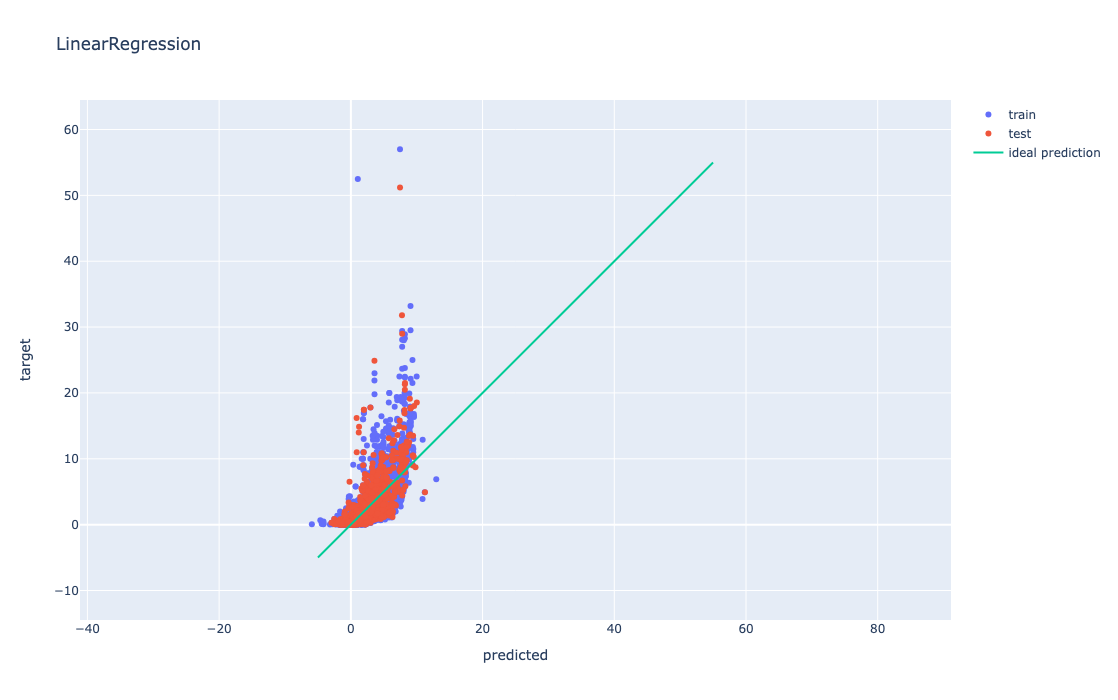

In [120]:
    # predictions visualization
layout = go.Layout(
    autosize=False,
    width=700,
    height=700,
)

fig = go.Figure(layout=layout)
low_lim = -10
up_lim = 60
delta = 5

fig.add_trace(go.Scatter(x=clf_lin.predict(X_train), y=y_train, mode='markers', name='train'))
fig.add_trace(go.Scatter(x=y_pred_lin, y=y_test, mode='markers', name='test'))

fig.add_trace(go.Scatter(
    x=[low_lim + delta, up_lim - delta], y=[low_lim + delta, up_lim - delta], 
    mode='lines', name='ideal prediction'
    )
)


fig.update_layout(
    title='LinearRegression',
    xaxis_title='predicted',
    yaxis_title='target'
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
)
fig.update_xaxes(range=[low_lim, up_lim])
fig.update_yaxes(range=[low_lim, up_lim])

fig.show()
fig.write_html('models_perfomance/linear_regression.html')

**Opinion:** There are so many variables (including categorical ones) in our dataset with , hence, it would be usefull to try Neural Network for `price` prediction in that task.

### RandomForest

At the end, let's try to use `RandomForest` classifier for our regression task.

In [90]:
%%time

clf_forest = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", RandomForestRegressor(
               n_estimators=10,
               criterion='absolute_error',
               max_depth=10,
               min_samples_leaf=5
           )
           )
          ]
)

clf_forest.fit(X_train, y_train);

CPU times: user 1min, sys: 107 ms, total: 1min
Wall time: 1min 6s


In [91]:
y_pred_forest = clf_forest.predict(X_test) 
l1_score_forest = np.abs(y_pred_forest - y_test).mean()  # l1-score

print(f'l1-score for forest model: {l1_score_forest:.6f}')
print(f'R^2 score for forest model: {clf_forest.score(X_test, y_test):.6f}')

l1-score for dummy model: 0.259380
R^2 score for dummy model: 0.824286


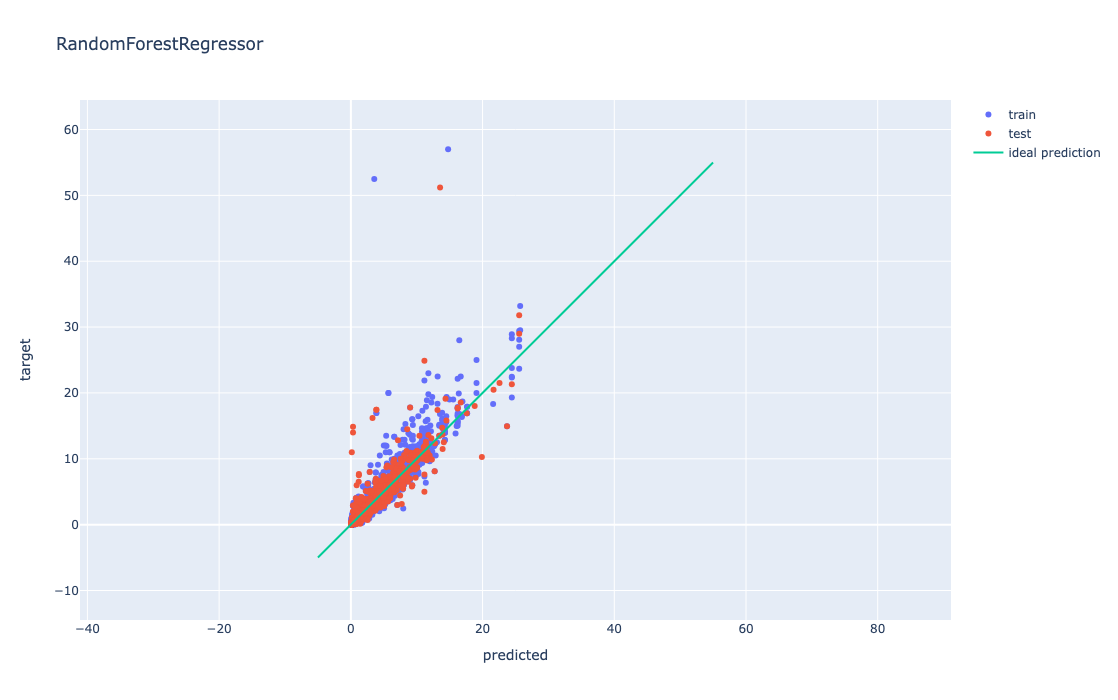

In [121]:
    # predictions visualization
layout = go.Layout(
    autosize=False,
    width=700,
    height=700,
)

fig = go.Figure(layout=layout)
low_lim = -10
up_lim = 60
delta = 5

fig.add_trace(go.Scatter(x=clf_forest.predict(X_train), y=y_train, mode='markers', name='train'))
fig.add_trace(go.Scatter(x=y_pred_forest, y=y_test, mode='markers', name='test'))

fig.add_trace(go.Scatter(
    x=[low_lim + delta, up_lim - delta], y=[low_lim + delta, up_lim - delta], 
    mode='lines', name='ideal prediction'
    )
)


fig.update_layout(
    title='RandomForestRegressor',
    xaxis_title='predicted',
    yaxis_title='target'
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
)
fig.update_xaxes(range=[low_lim, up_lim])
fig.update_yaxes(range=[low_lim, up_lim])

fig.show()
fig.write_html('models_perfomance/random_forest.html')

Mutch better results even withoutoptimization of `RandomForestRegressor`!